# Concurrency in Image Processing Applications
Most data science on image processing requires reading and/or processing a large number of image files. This often results in a very slow workflow due the time to read each image, especially if naively done in serious. Here we will look at different ways to improve the throughput of two image processing tasks: one task is lightweight in terms of CPU usage so we expect it to be I/O-bound, the second task is more CPU-intensive and it is not clear whether it will be I/O or CPU-bound.

We will use the Valeo Woodscape dataset of autonomous driving images which is available [here](https://woodscape.valeo.com/woodscape/dataset). **NOTE** The original dataset has 8,234 images consuming about 14GB of disk storage for the plain RGB images.

In [52]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pathlib import Path
import cv2
from PIL import Image
import numpy as np
from time import time
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

In [15]:
# setup paths to the data files
dataset_path = Path("./woodscape")
rgb_path = dataset_path.joinpath("rgb_images")
semseg_path = dataset_path.joinpath("semantic_annotations/gtLabels")

# get list of images, see how they are named
rgb_frame_paths = list(rgb_path.glob("*.png"))
semseg_frame_paths = list(semseg_path.glob("*.png"))
print(f"RGB Images from {rgb_path}")
print([image.name for image in rgb_frame_paths[:6]])
print(f"Semantic Segmentation Images from {semseg_path}")
print([image.name for image in semseg_frame_paths[0:6]])

RGB Images from woodscape/rgb_images
['00000_FV.png', '00001_FV.png', '00002_FV.png', '00003_FV.png', '00004_FV.png', '00005_FV.png']
Semantic Segmentation Images from woodscape/semantic_annotations/gtLabels
['00000_FV.png', '00001_FV.png', '00002_FV.png', '00003_FV.png', '00004_FV.png', '00005_FV.png']


## Sanity check of data
To make sure we’ve got our data lining up, let’s make a quick overlay of an RGB and semantic mask

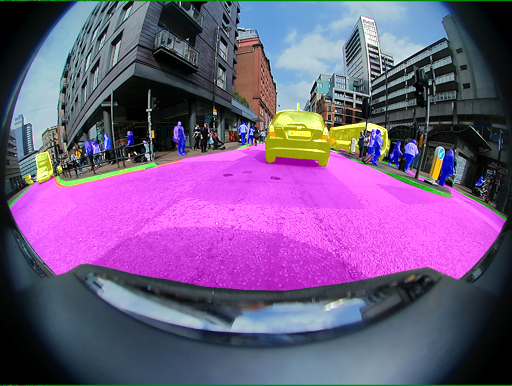

In [37]:
def create_semantic_overlay(img_path, semseg_path, scale=0.4, opacity=0.6):

    rgb_frame = cv2.imread(str(img_path))[..., ::-1]
    semseg_frame = cv2.imread(str(semseg_path))
    h, w, _ = rgb_frame.shape
    rgb_out = np.asarray(Image.fromarray(rgb_frame).resize((int(w*scale), int(h*scale))))
    semseg_out = np.asarray(Image.fromarray(semseg_frame).resize((int(w*scale), int(h*scale))))
    img_out = cv2.addWeighted(rgb_out, 1.0, semseg_out, opacity, gamma=0.0)

    return img_out

semseg_rgb_path = dataset_path.joinpath("semantic_annotations/rgbLabels")
semseg_frame_path = next(semseg_rgb_path.glob("*.png"))
img = create_semantic_overlay(rgb_frame_paths[0], semseg_frame_path)
Image.fromarray(img)

## Setup a parallizable function
First create some dictionaries in which to accumulate statistics (number of pixels from all images in each class).

In [32]:
# The semantic mapping for woodscape
WS_SEMSEG_ID_TO_LABEL = {
    0: "void",
    1: "road",
    2: "lanemarks",
    3: "curb",
    4: "person",
    5: "rider",
    6: "vehicles",
    7: "bicycle",
    8: "motorcycle",
    9: "traffic_sign",
}
WS_SEMSEG_LABEL_TO_ID = {v: k for k, v in WS_SEMSEG_ID_TO_LABEL.items()}

In [42]:
def get_class_pixel_counts(semseg_path):

    class_counts = {k: 0 for k in WS_SEMSEG_LABEL_TO_ID.keys()}
    gt_mask = cv2.imread(str(semseg_path), cv2.IMREAD_UNCHANGED)
    class_ids, class_pixel_counts = np.unique(gt_mask, return_counts=True)
    for class_id, class_pixel_count in zip(class_ids, class_pixel_counts):
        class_counts[WS_SEMSEG_ID_TO_LABEL[class_id]] = class_pixel_count

    return class_counts

In [44]:
# sanity check on a single image
get_class_pixel_counts(semseg_frame_paths[0])

{'void': 877494,
 'road': 310862,
 'lanemarks': 1489,
 'curb': 5641,
 'person': 13124,
 'rider': 0,
 'vehicles': 27608,
 'bicycle': 0,
 'motorcycle': 0,
 'traffic_sign': 262}

## Standard way of processing images
Here we read one image at a time and then process it (get the number of each pixels in each category for the current image, then add these counts to the grand total)

In [53]:
start = time()
total_class_pixel_counts = {class_label: 0 for class_label in WS_SEMSEG_LABEL_TO_ID.keys()}
for semseg_frame_path in semseg_frame_paths:
    frame_pixel_counts = get_class_pixel_counts(semseg_frame_path)
    for class_label, class_pixel_count in frame_pixel_counts.items():
        total_class_pixel_counts[class_label] += class_pixel_count

print(f"Gathering data took {time() - start:.3g} secs")

Gathering data took 40.9 secs


In [54]:
total_class_pixel_counts

{'void': 1767280415,
 'road': 614768741,
 'lanemarks': 35623570,
 'curb': 17899914,
 'person': 8507793,
 'rider': 3921738,
 'vehicles': 65914982,
 'bicycle': 14555299,
 'motorcycle': 2733417,
 'traffic_sign': 1105171}

## Using multithreading

In [57]:
start = time()
total_class_pixel_counts = {class_label: 0 for class_label in WS_SEMSEG_LABEL_TO_ID.keys()}
with ThreadPoolExecutor() as threadpool:
    frame_futures = set()
    for semseg_frame_path in semseg_frame_paths:
        frame_futures.add(threadpool.submit(get_class_pixel_counts, semseg_frame_path))
    for res in as_completed(frame_futures):
        frame_pixel_counts = res.result()
        for class_label, class_pixel_count in frame_pixel_counts.items():
            total_class_pixel_counts[class_label] += class_pixel_count

print(f"Gathering data took {time() - start:.3g} secs")

Gathering data took 11.7 secs


## Using multiprocessing
The mulitprocessing module cannot run functions from within the memory space of a Jupyter notebook, so we first need to create a file of the get_pixel_class_counts function, which we will then later import

In [63]:
script_string = """
import cv2
import numpy as np
WS_SEMSEG_ID_TO_LABEL = {
    0: "void",
    1: "road",
    2: "lanemarks",
    3: "curb",
    4: "person",
    5: "rider",
    6: "vehicles",
    7: "bicycle",
    8: "motorcycle",
    9: "traffic_sign",
}
WS_SEMSEG_LABEL_TO_ID = {v: k for k, v in WS_SEMSEG_ID_TO_LABEL.items()}
def get_class_pixel_counts(semseg_path):
    class_counts = {k: 0 for k in WS_SEMSEG_LABEL_TO_ID.keys()}
    gt_mask = cv2.imread(str(semseg_path), cv2.IMREAD_UNCHANGED)
    class_ids, class_pixel_counts = np.unique(gt_mask, return_counts=True)
    for class_id, class_pixel_count in zip(class_ids, class_pixel_counts):
        class_counts[WS_SEMSEG_ID_TO_LABEL[class_id]] = class_pixel_count
    return class_counts
"""
with open("zz_class_pixel_counts.py", "w") as f:
    f.write(script_string)

In [64]:
from zz_class_pixel_counts import get_class_pixel_counts

In [66]:
start = time()
total_class_pixel_counts = {class_label: 0 for class_label in WS_SEMSEG_LABEL_TO_ID.keys()}
with ProcessPoolExecutor() as pool:
    frame_futures = set()
    for semseg_frame_path in semseg_frame_paths:
        frame_futures.add(pool.submit(get_class_pixel_counts, semseg_frame_path))
    for res in as_completed(frame_futures):
        frame_pixel_counts = res.result()
        for class_label, class_pixel_count in frame_pixel_counts.items():
            total_class_pixel_counts[class_label] += class_pixel_count

print(f"Gathering data took {time() - start:.3g} secs")

Gathering data took 12.2 secs
